## Семинар 2 "Распознавание рукописных цифр"

ФИО: Смирнов Михаил Андреевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import sys

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
from skimage.transform import rotate
from skimage.util import img_as_float
from copy import copy

%matplotlib inline

In [100]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [50]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

In [60]:
i=0
for X, y in iter(train_loader):
    i+=1
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

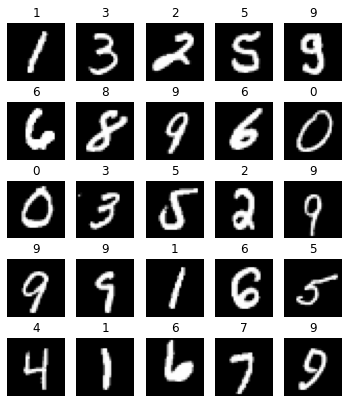

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [6]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.323/0.316	Accuracy: 0.915/0.917

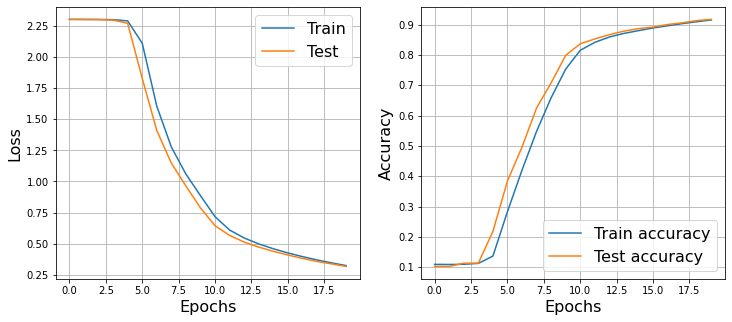

In [7]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [11]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [12]:
# class ReLU:
#     def __init__(self):
#         pass

#     def forward(self, X):
#         '''
#         Passes objects through this layer.
#         X is np.array of size (N, d)
#         '''
#         self.X = X
#         return np.maximum(X, 0)

#     def backward(self, dLdy):
#         '''
#         1. Compute dLdx.
#         2. Return dLdx
#         '''
#         dydX = (self.X >= 0).astype(float)
#         return dLdy*dydX

#     def step(self, learning_rate):
#         pass

In [13]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.036/0.087	Accuracy: 0.990/0.976

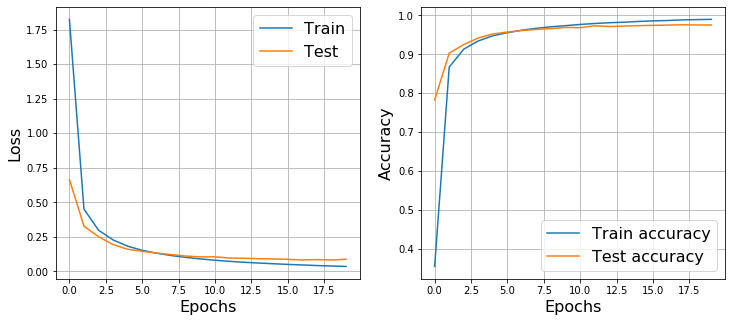

In [14]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.046/0.081	Accuracy: 0.987/0.974

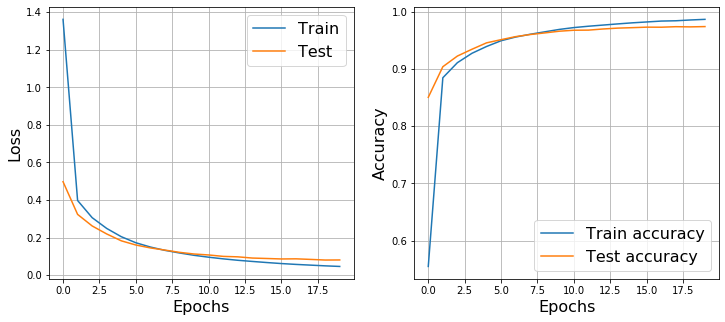

In [15]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

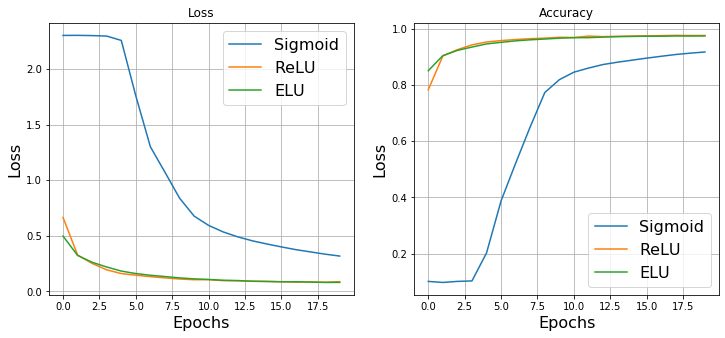

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [101]:
class Tanh:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
#         return (np.exp(self.a*X) - np.exp(-self.a*X))/(np.exp(self.a*X) + np.exp(-self.a*X))
        return np.tanh(X)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = 1 - (self.forward(X))**2
        return dydX*dLdy

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.031/0.077	Accuracy: 0.994/0.975

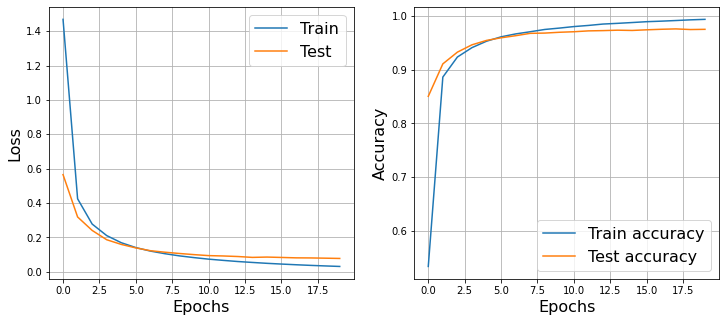

In [102]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=True, verbose=True)

### Часть 3: Анализ ошибок

In [8]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

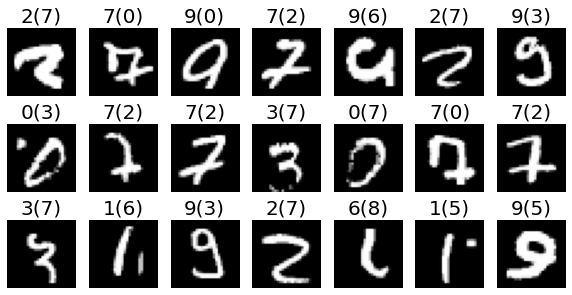

In [9]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [80]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

transform_r = transforms.Compose([transforms.RandomAffine(degrees=20),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])

transform_sh = transforms.Compose([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))])

transform_nz = transforms.Compose([transforms.GaussianBlur((5, 5), sigma=(0.1, 2.0)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))])

In [81]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_rotated = MNIST('.', train=True, download=True, transform=transform_r)

train_shifted = MNIST('.', train=True, download=True, transform=transform_sh)

train_noized = MNIST('.', train=True, download=True, transform=transform_nz)

In [82]:
train_loader = DataLoader(train_dataset + train_rotated, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Rotation augmentation, sigmoid activation function

Epoch 19... (Train/Test) NLL: 0.165/0.143	Accuracy: 0.954/0.959

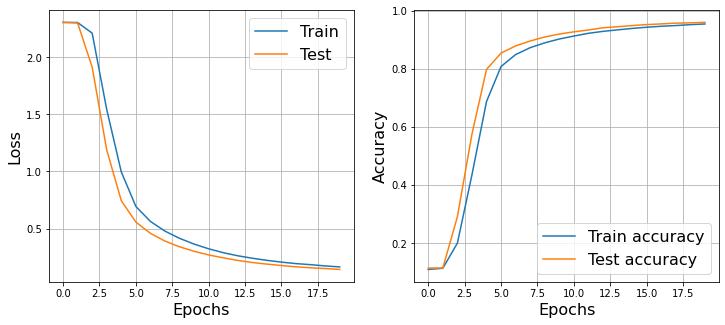

In [83]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()
tr_s_rot, ts_s_rot, tr_ac_s_rot, ts_ac_s_rot = train(network, 20, 0.01, plot=True, verbose=True)

Shift augmentation, sigmoid activation function

In [84]:
train_loader = DataLoader(train_dataset + train_shifted, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.364/0.182	Accuracy: 0.895/0.951

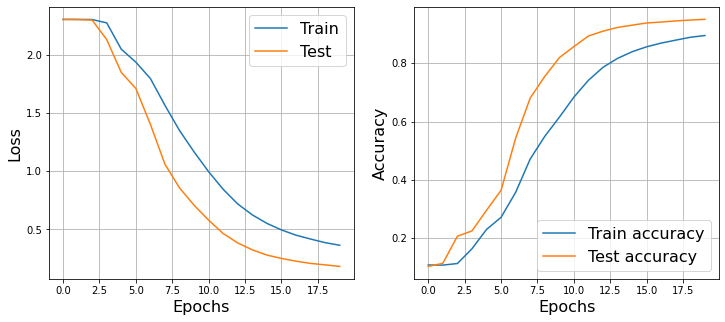

In [85]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()
tr_s_shift, ts_s_shift, tr_ac_s_shift, ts_ac_s_shift = train(network, 20, 0.01, plot=True, verbose=True)

Noize augmentation, sigmoid activation function

In [86]:
train_loader = DataLoader(train_dataset + train_noized, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.159/0.159	Accuracy: 0.956/0.956

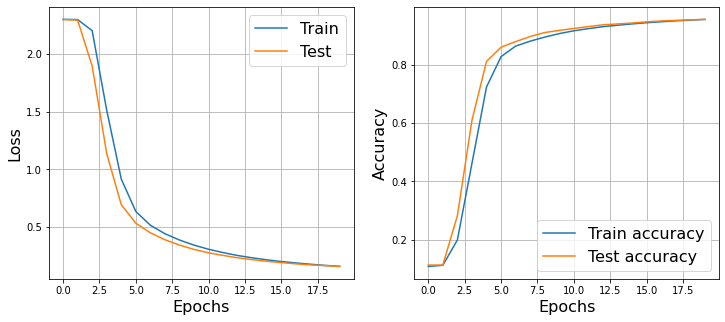

In [87]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()
tr_s_noize, ts_s_noize, tr_ac_s_noize, ts_ac_s_noize = train(network, 20, 0.01, plot=True, verbose=True)

Rotation, shift and noize augmentation, sigmoid activation function

In [88]:
train_loader = DataLoader(train_dataset + train_rotated + train_shifted + train_noized, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 19... (Train/Test) NLL: 0.178/0.089	Accuracy: 0.947/0.972

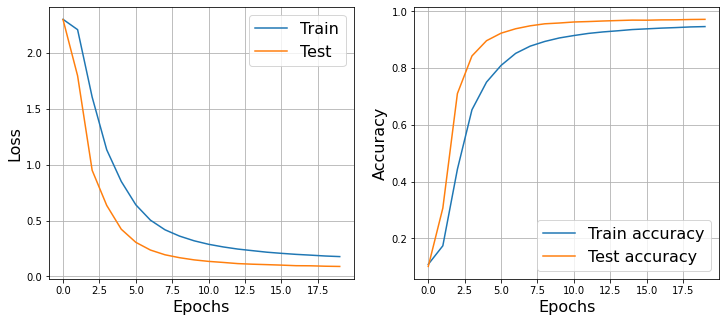

In [89]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(),
               Linear(100, 100), Sigmoid(),
               Linear(100, 10)])
loss = NLLLoss()
tr_s_all, ts_s_all, tr_ac_s_all, ts_ac_s_all = train(network, 20, 0.01, plot=True, verbose=True)

Rotation, shift and noize augmentation, Tanh activation function

Epoch 19... (Train/Test) NLL: 0.092/0.061	Accuracy: 0.972/0.980

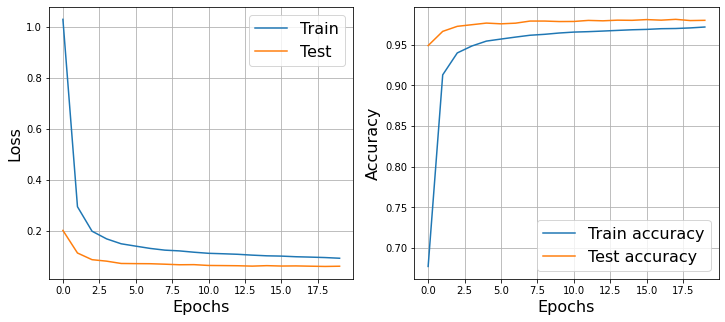

In [90]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_t_all, ts_t_all, tr_ac_t_all, ts_ac_t_all = train(network, 20, 0.01, plot=True, verbose=True)

### (X + noize(5, 5) + rolled + shifted)

In [124]:
def draw_graphs(mode = "s"):
    
    plt.figure(figsize=(7, 7))
    if mode == "s":
        plt.plot(ts_ac_s, label="No augmentation")
        plt.plot(ts_ac_s_rot, label="Rotation +-20 deg")
        plt.plot(ts_ac_s_shift, label="Shift", c='y')
        plt.plot(ts_ac_s_noize, label="Noize", c='r')
        plt.plot(ts_ac_s_all, label="All augmentations", c='purple')
    elif mode == "t":
        plt.plot(ts_ac_t, label="No augmentation", c='y')
        plt.plot(ts_ac_t_all, label="All augmentations", c='r')
    plt.legend()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Можно сделать вывод, что расширение обучающей выбоки различными аугментациями дает существенный прирост в точности.
Для нейронной сети с сигмойдной функцией активации при применении аугментаций вращения, сдвигов и зашумления по отдельности, наилучший результат был достигнут при добавлении вращений, accuracy = 0.959 на тесте за 20 эпох обучения

Так же при совместном использовании аугментаций точность еще выше и равна 0.972. Без аугментаций при таком же количестве эпох на той же сети достигалось лишь 0.917

Для наглядности я построил график

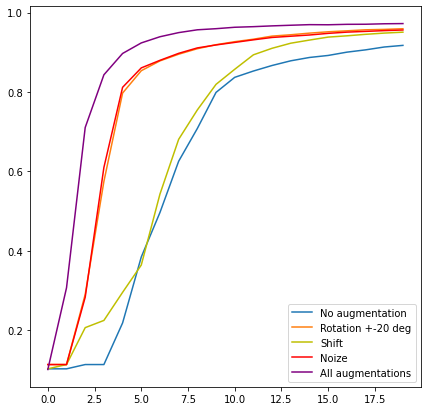

In [125]:
draw_graphs("s")

На сети с гиперболическим тангенсом аугментации так же немного улучшили точность на тесте, улучшение не так существенно потому что тангенс и без того неплохо работает, думаю подобрав другую сеть и увеличив количество эпох, можно достичь большего прироста

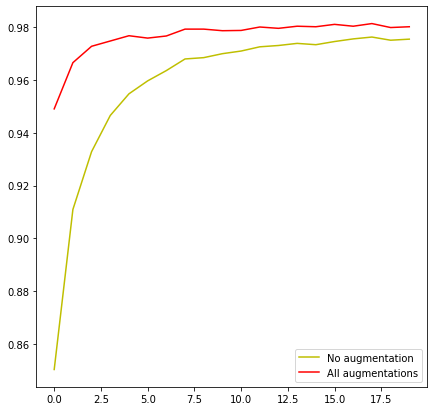

In [126]:
draw_graphs("t")

Old useless functions, it's sad to delete them

In [13]:
# def rotate_img(im, angle=15):
    
#     angle = int(np.random.random()) * angle
    
#     im = im[0]
#     im_f = img_as_float(im)
#     n_im = rotate(im_f, 15, cval=im_f[0][0])
    
#     return n_im.reshape(1, 28, 28)

In [18]:
# def calculate_func(X, y, func, **params):
    
#     new_im = func(X[1], **params)
#     X_n = new_im.reshape(1, 1, 28, 28)
#     y_n = y[1]
    
#     for i in range(1, X.shape[0]):
        
#         new_im = func(X[i], **params)
#         new_im = new_im.reshape(1, 1, 28, 28)
#         X_n = np.vstack((X_n, new_im))
#         y_n = np.hstack((y_n, y[i]))
        
#     return X_n, y_n

In [28]:
# def shift_img(im):
    
#     im = im[0]
#     sh = int((np.random.random() - 0.5) * 12)

#     b = np.zeros(28*np.abs(sh)) + im[0][0]
#     b = b.reshape(28, sh)
    
#     im = im[:, -sh:] if sh <= 0 else im[:, :im.shape[1]-sh]   
#     im = np.hstack((im, b)) if sh <= 0 else np.hstack((b, im))
    
#     return im.reshape(1, 28, 28)

In [41]:
# def noize_img(image, ker=(5, 5)):
    
#     image = image.reshape(28,28)
#     new_image = cv2.GaussianBlur(image, ker, 0, cv2.BORDER_ISOLATED)
    
#     return new_image.reshape(1, 28, 28)